In [31]:
!pip install pandas scikit-learn xgboost imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE


In [32]:
from google.colab import files

# Upload dataset
uploaded = files.upload()

# Load dataset
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)



Saving fully_mapped_crime_hotspot_data.csv to fully_mapped_crime_hotspot_data (7).csv


In [33]:
print(df.columns)

df.rename(columns={'location': 'city'}, inplace=True)
print(df.info)


Index(['location', 'crime_type', 'time', 'date', 'investigation_status',
       'case_number', 'comments', 'latitude', 'longitude', 'crime_category',
       'hour', 'day_of_week', 'month'],
      dtype='object')
<bound method DataFrame.info of                  city          crime_type      time        date  \
0        LODHI COLONY            gangrape  22:31:00  2020-06-15   
1         MANDIR MARG  sexual harassement  15:47:00  2019-09-28   
2         TUGLAK ROAD            gangrape  01:34:00  2020-06-19   
3        PANDAV NAGAR               theft  12:32:00  2019-10-28   
4            GHAZIPUR             robbery  15:47:00  2019-08-31   
...               ...                 ...       ...         ...   
3495     NEW USMANPUR                rape  10:12:00  2019-09-28   
3496     PUNJABI BAGH     assualt murders  03:06:00  2019-09-06   
3497        H. N. DIN                rape  01:11:00  2019-10-08   
3498      KIRTI NAGAR  sexual harassement  16:39:00  2020-03-17   
3499  GREATER KAILA

In [35]:
print(X.select_dtypes(include=['object']).columns)


Index([], dtype='object')


In [36]:
print(df[df.astype(str).apply(lambda x: x.str.contains("Open", na=False)).any(axis=1)])


                 city          crime_type      time        date  \
0        LODHI COLONY            gangrape  22:31:00  2020-06-15   
3        PANDAV NAGAR               theft  12:32:00  2019-10-28   
7       SAMAYPURBADLI            gangrape  04:20:00  2019-10-28   
9           PAHARGANJ            gangrape  06:53:00  2019-09-06   
10    GREATER KAILASH                rape  15:52:00  2019-11-14   
...               ...                 ...       ...         ...   
3486      ASHOK VIHAR  sexual harassement  11:23:00  2019-09-23   
3487     FARASH BAZAR     assualt murders  08:25:00  2019-07-15   
3490    KASHMERE GATE              murder  23:44:00  2020-03-28   
3493       JANAK PURI     assualt murders  16:29:00  2020-04-20   
3498      KIRTI NAGAR  sexual harassement  16:39:00  2020-03-17   

     investigation_status case_number comments  latitude  longitude  \
0                    Open       C8160        -   28.5933    77.2273   
3                    Open       C1009        -   28.6

In [37]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])


In [40]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 📌 Step 1: Upload & Load Dataset
# already uploaded

# 📌 Step 2: Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 📌 Step 3: Extract new features (year, month, day, hour)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Convert 'time' column safely (if it exists)
if 'time' in df.columns:
    df['hour'] = pd.to_datetime(df['time'], errors='coerce').dt.hour.fillna(0).astype(int)
else:
    df['hour'] = 0  # Assign default value if time column is missing

# 📌 Step 4: Fill missing values
df.fillna("Unknown", inplace=True)

# 📌 Step 5: Encode categorical features
categorical_cols = ['location', 'crime_category', 'day_of_week']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 📌 Step 6: Select features & target
target_column = 'crime_type'
if target_column not in df.columns:
    raise ValueError(f"Column '{target_column}' is missing in the dataset")

X = df_encoded.drop(columns=['crime_type', 'location', 'time', 'date'], errors='ignore')
y = LabelEncoder().fit_transform(df[target_column])

# 📌 Step 7: Check for any non-numeric data in features
non_numeric_cols = X.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns detected: {non_numeric_cols}")

    # Convert them using Label Encoding
    label_encoders = {}
    for col in non_numeric_cols:
        label_encoders[col] = LabelEncoder()
        X[col] = label_encoders[col].fit_transform(X[col])

# 📌 Step 8: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 📌 Step 9: Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 📌 Step 10: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("✅ Data preprocessing completed successfully!")


<ipython-input-40-8d56decbab3c>:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['time'], errors='coerce').dt.hour.fillna(0).astype(int)


Non-numeric columns detected: Index(['investigation_status', 'case_number', 'comments'], dtype='object')
✅ Data preprocessing completed successfully!


In [41]:
# Train an XGBoost model (Better than Random Forest)
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")
print(report)


✅ Model Accuracy: 60.79%
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       105
           1       0.50      0.50      0.50       105
           2       0.59      0.64      0.61       105
           3       0.54      0.47      0.50       106
           4       0.61      0.56      0.58       105
           5       0.50      0.49      0.49       105
           6       1.00      1.00      1.00       106

    accuracy                           0.61       737
   macro avg       0.61      0.61      0.61       737
weighted avg       0.61      0.61      0.61       737



In [42]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Predictions with Best Model
y_pred_best = best_model.predict(X_test)

# Evaluate
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"🔥 Optimized Model Accuracy: {accuracy_best * 100:.2f}%")


🔥 Optimized Model Accuracy: 60.65%


In [42]:
# visualization on map

In [43]:
!pip install folium


In [44]:
import folium
from folium.plugins import MarkerCluster

# Create a map centered at an average location
map_center = [df["latitude"].mean(), df["longitude"].mean()]
crime_map = folium.Map(location=map_center, zoom_start=10)

# Add marker clusters for crimes
marker_cluster = MarkerCluster().add_to(crime_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"Crime: {row['crime_type']}\nDate: {row['date']}\nLocation: {row['location']}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(marker_cluster)

# Show map
crime_map


In [53]:
def show_city_crimes(city_name):
    city_df = df[df["location"] == city_name]

    if city_df.empty:
        print(f"No crime data found for {city_name}")
        return None

    # Center map on the city
    city_center = [city_df["latitude"].mean(), city_df["longitude"].mean()]
    city_map = folium.Map(location=city_center, zoom_start=12)

    # Add crimes for the city
    for _, row in city_df.iterrows():
        folium.Marker(
            location=[row["latitude"], row["longitude"]],
            popup=f"Crime: {row['crime_type']}\nDate: {row['date']}",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(city_map)

    return city_map

# Example usage
show_city_crimes("LODHI COLONY")  # Replace with any city name
# here , you can change the name of the city to check out where is the city or like if you need to check whether the city is in your data set or not.
# like if we search  New York instead of LODHI COLONY as a city it will throw that its not there in your data base

In [50]:
#AI graphs for ai predictions

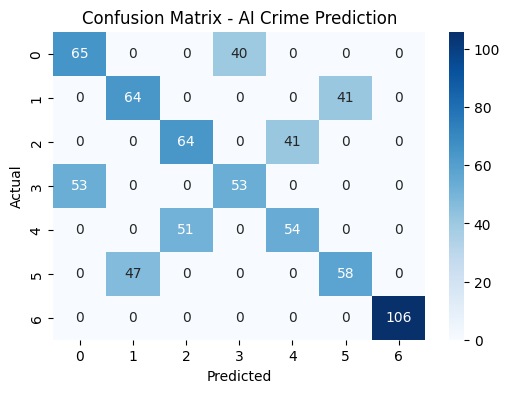

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.62      0.58       105
           1       0.58      0.61      0.59       105
           2       0.56      0.61      0.58       105
           3       0.57      0.50      0.53       106
           4       0.57      0.51      0.54       105
           5       0.59      0.55      0.57       105
           6       1.00      1.00      1.00       106

    accuracy                           0.63       737
   macro avg       0.63      0.63      0.63       737
weighted avg       0.63      0.63      0.63       737



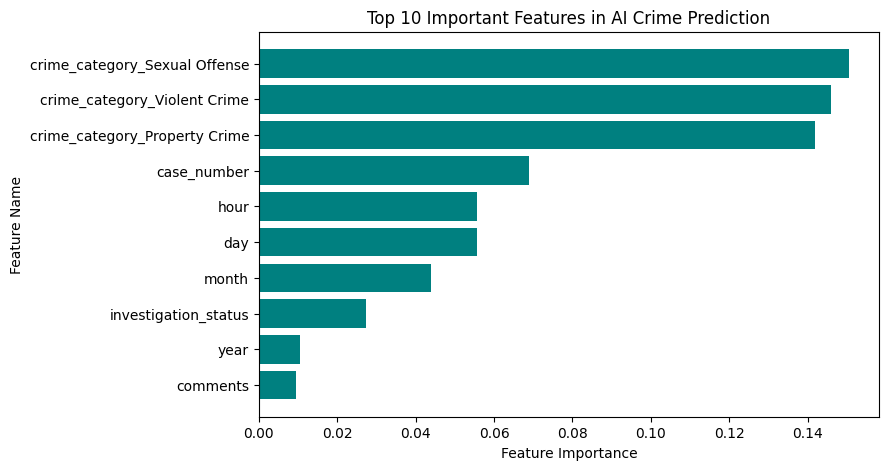

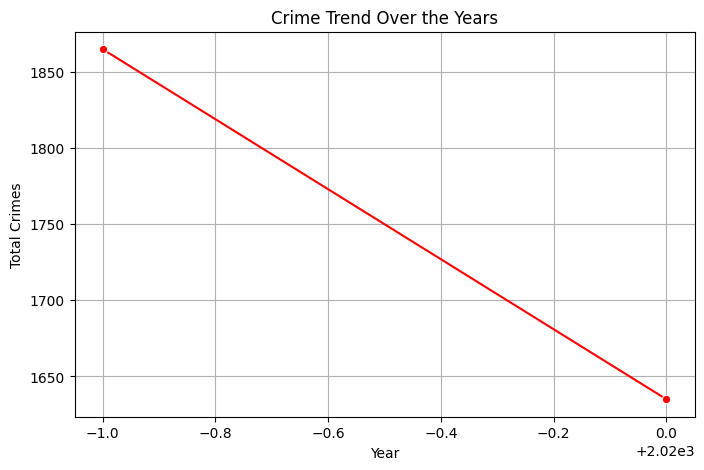

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 📌 Step 1: Train a Simple AI Model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📌 Step 2: Make Predictions
y_pred = model.predict(X_test)

# 📌 Step 3: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AI Crime Prediction")
plt.show()

# 📌 Step 4: Classification Report
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 5: Feature Importance Plot
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 important features

plt.figure(figsize=(8, 5))
plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features in AI Crime Prediction")
plt.show()

# 📌 Step 6: Crime Trend Analysis (Time-based)
df['crime_count'] = 1
crime_trend = df.groupby('year')['crime_count'].sum()

plt.figure(figsize=(8, 5))
sns.lineplot(x=crime_trend.index, y=crime_trend.values, marker='o', color='red')
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.title("Crime Trend Over the Years")
plt.grid(True)
plt.show()


In [49]:
#graphical representations

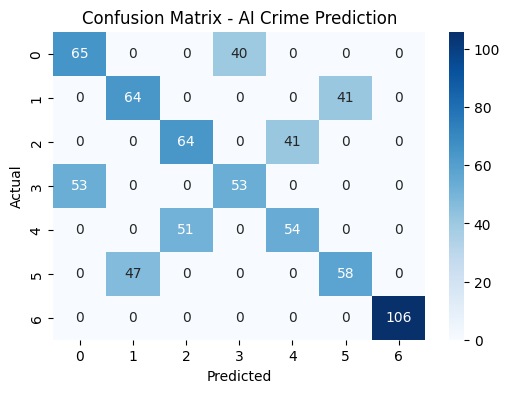

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.62      0.58       105
           1       0.58      0.61      0.59       105
           2       0.56      0.61      0.58       105
           3       0.57      0.50      0.53       106
           4       0.57      0.51      0.54       105
           5       0.59      0.55      0.57       105
           6       1.00      1.00      1.00       106

    accuracy                           0.63       737
   macro avg       0.63      0.63      0.63       737
weighted avg       0.63      0.63      0.63       737



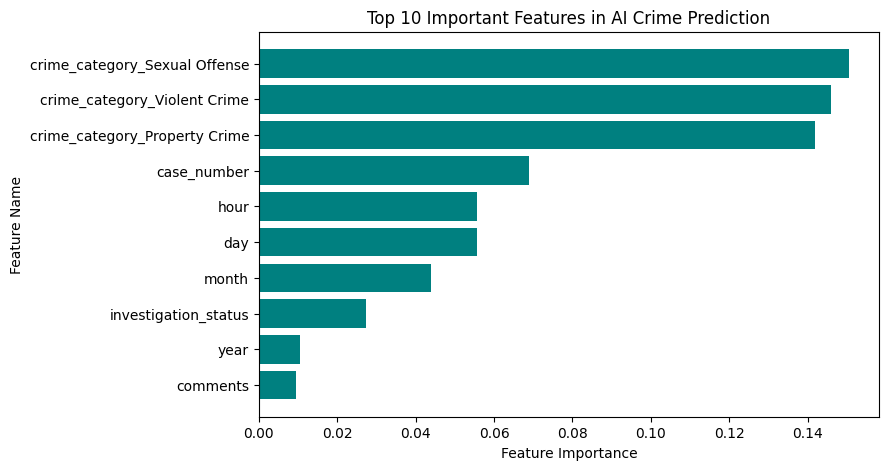

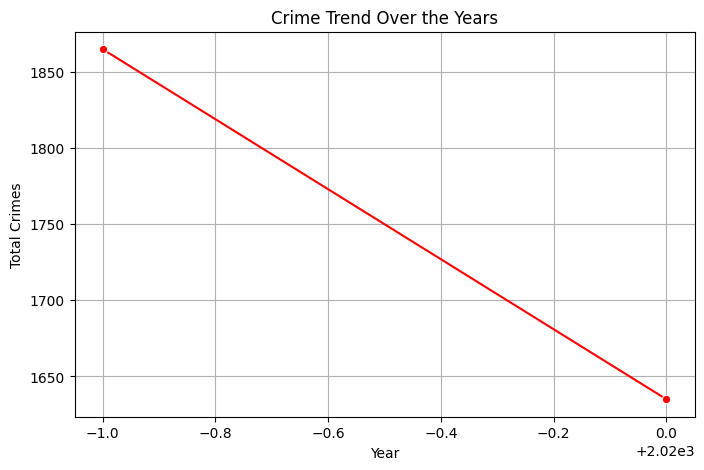

<ipython-input-48-69703229565f>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['location'].value_counts().index[:10], y=df['location'].value_counts().values[:10], palette="coolwarm")


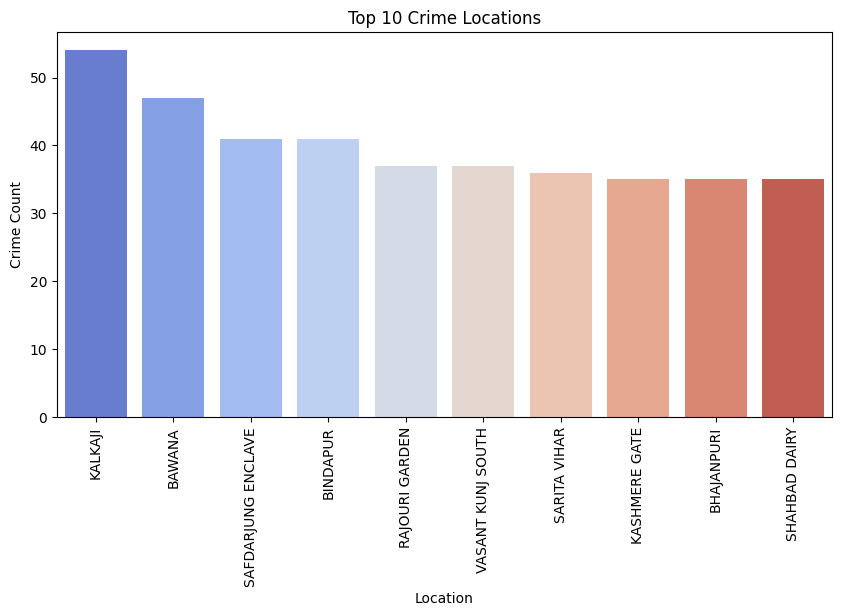

<ipython-input-48-69703229565f>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['hour'].apply(lambda x: 'Night' if x < 6 or x > 18 else 'Day'), palette=['darkblue', 'pink'])


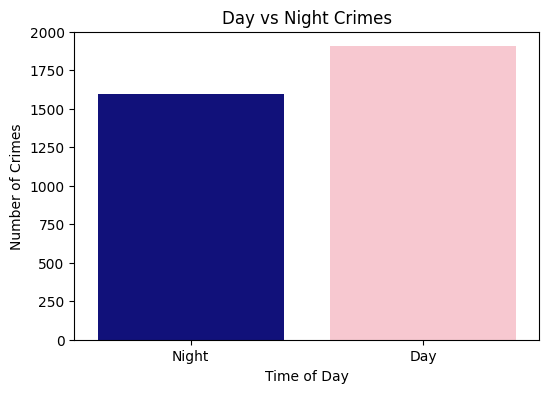

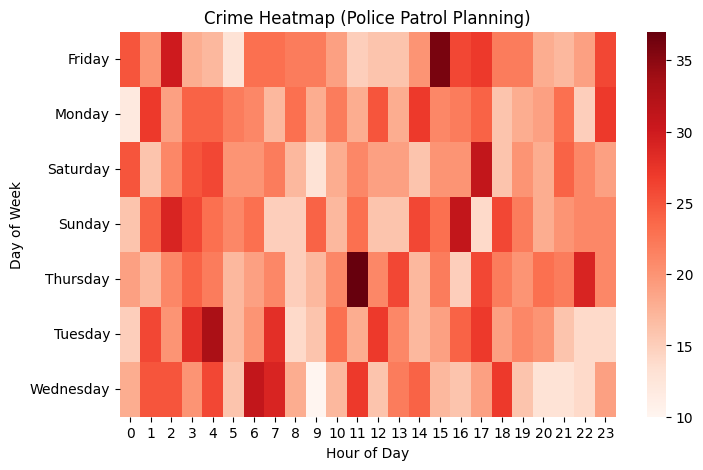

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# 📌 Step 4: Train AI Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 📌 Step 5: Make Predictions
y_pred = model.predict(X_test)

# 📌 Step 6: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - AI Crime Prediction")
plt.show()

# 📌 Step 7: Classification Report
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 8: Feature Importance Plot
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 important features

plt.figure(figsize=(8, 5))
plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='teal')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features in AI Crime Prediction")
plt.show()

# 📌 Step 9: Crime Trend Analysis (Time-based)
df['crime_count'] = 1
crime_trend = df.groupby('year')['crime_count'].sum()

plt.figure(figsize=(8, 5))
sns.lineplot(x=crime_trend.index, y=crime_trend.values, marker='o', color='red')
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.title("Crime Trend Over the Years")
plt.grid(True)
plt.show()

# 📌 Step 10: Crime Hotspot Heatmap
crime_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)
heat_data = list(zip(df['latitude'], df['longitude'], df['crime_count']))
HeatMap(heat_data).add_to(crime_map)
crime_map.save("Crime_Hotspot_Map.html")

# 📌 Step 11: Crime Frequency by Location
plt.figure(figsize=(10, 5))
sns.barplot(x=df['location'].value_counts().index[:10], y=df['location'].value_counts().values[:10], palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Location")
plt.ylabel("Crime Count")
plt.title("Top 10 Crime Locations")
plt.show()

# 📌 Step 12: Women’s Safety - Day vs Night Crimes
plt.figure(figsize=(6, 4))
sns.countplot(x=df['hour'].apply(lambda x: 'Night' if x < 6 or x > 18 else 'Day'), palette=['darkblue', 'pink'])
plt.xlabel("Time of Day")
plt.ylabel("Number of Crimes")
plt.title("Day vs Night Crimes")
plt.show()

# 📌 Step 13: Police Patrol Optimization - Crime Heatmap by Day
plt.figure(figsize=(8, 5))
sns.heatmap(df.pivot_table(index="day_of_week", columns="hour", values="crime_count", aggfunc="sum"), cmap="Reds")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title("Crime Heatmap (Police Patrol Planning)")
plt.show()
